In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ahmedmohamed2003_cafe_sales_dirty_data_for_cleaning_training_path = kagglehub.dataset_download('ahmedmohamed2003/cafe-sales-dirty-data-for-cleaning-training')

print('Data source import complete.')


100%|██████████| 111k/111k [00:00<00:00, 437kB/s]

Extracting files...
Data source import complete.


<h1 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Import Libraries 📚
</h1>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import scipy.stats as stats
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

data_path = os.path.join(ahmedmohamed2003_cafe_sales_dirty_data_for_cleaning_training_path, 'dirty_cafe_sales.csv')
data = pd.read_csv(data_path)
df = data.copy()
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [ ]:
df.shape

(10000, 8)

<h1 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  EDA 📊
</h1>

<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Missing Data Analysis
</h3>

In [ ]:
df.isnull().sum()

,0
Transaction ID,0
Item,333
Quantity,138
Price Per Unit,179
Total Spent,173
Payment Method,2579
Location,3265
Transaction Date,159


In [ ]:
missing_percentage = df.isnull().mean() * 100

missing_table = pd.DataFrame({
    'Missing Data Percentage (%)': missing_percentage
}).reset_index().rename(columns={'index': 'Column'})

print(tabulate(missing_table, headers='keys', tablefmt='grid', showindex=False))

+------------------+-------------------------------+
| Column           |   Missing Data Percentage (%) |
+==================+===============================+
| Transaction ID   |                          0    |
+------------------+-------------------------------+
| Item             |                          3.33 |
+------------------+-------------------------------+
| Quantity         |                          1.38 |
+------------------+-------------------------------+
| Price Per Unit   |                          1.79 |
+------------------+-------------------------------+
| Total Spent      |                          1.73 |
+------------------+-------------------------------+
| Payment Method   |                         25.79 |
+------------------+-------------------------------+
| Location         |                         32.65 |
+------------------+-------------------------------+
| Transaction Date |                          1.59 |
+------------------+--------------------------

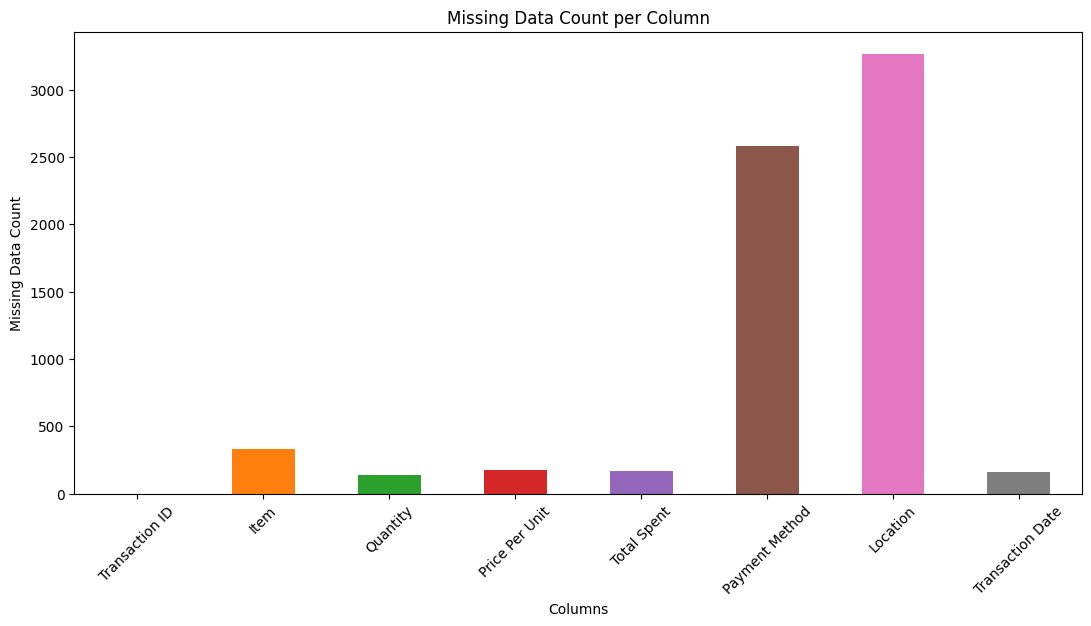

In [ ]:
missing_data_count = df.isnull().sum()
colors = plt.cm.tab10(range(len(missing_data_count)))

missing_data_count.plot(kind='bar', color=colors, figsize=(13,6))
plt.title('Missing Data Count per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Data Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

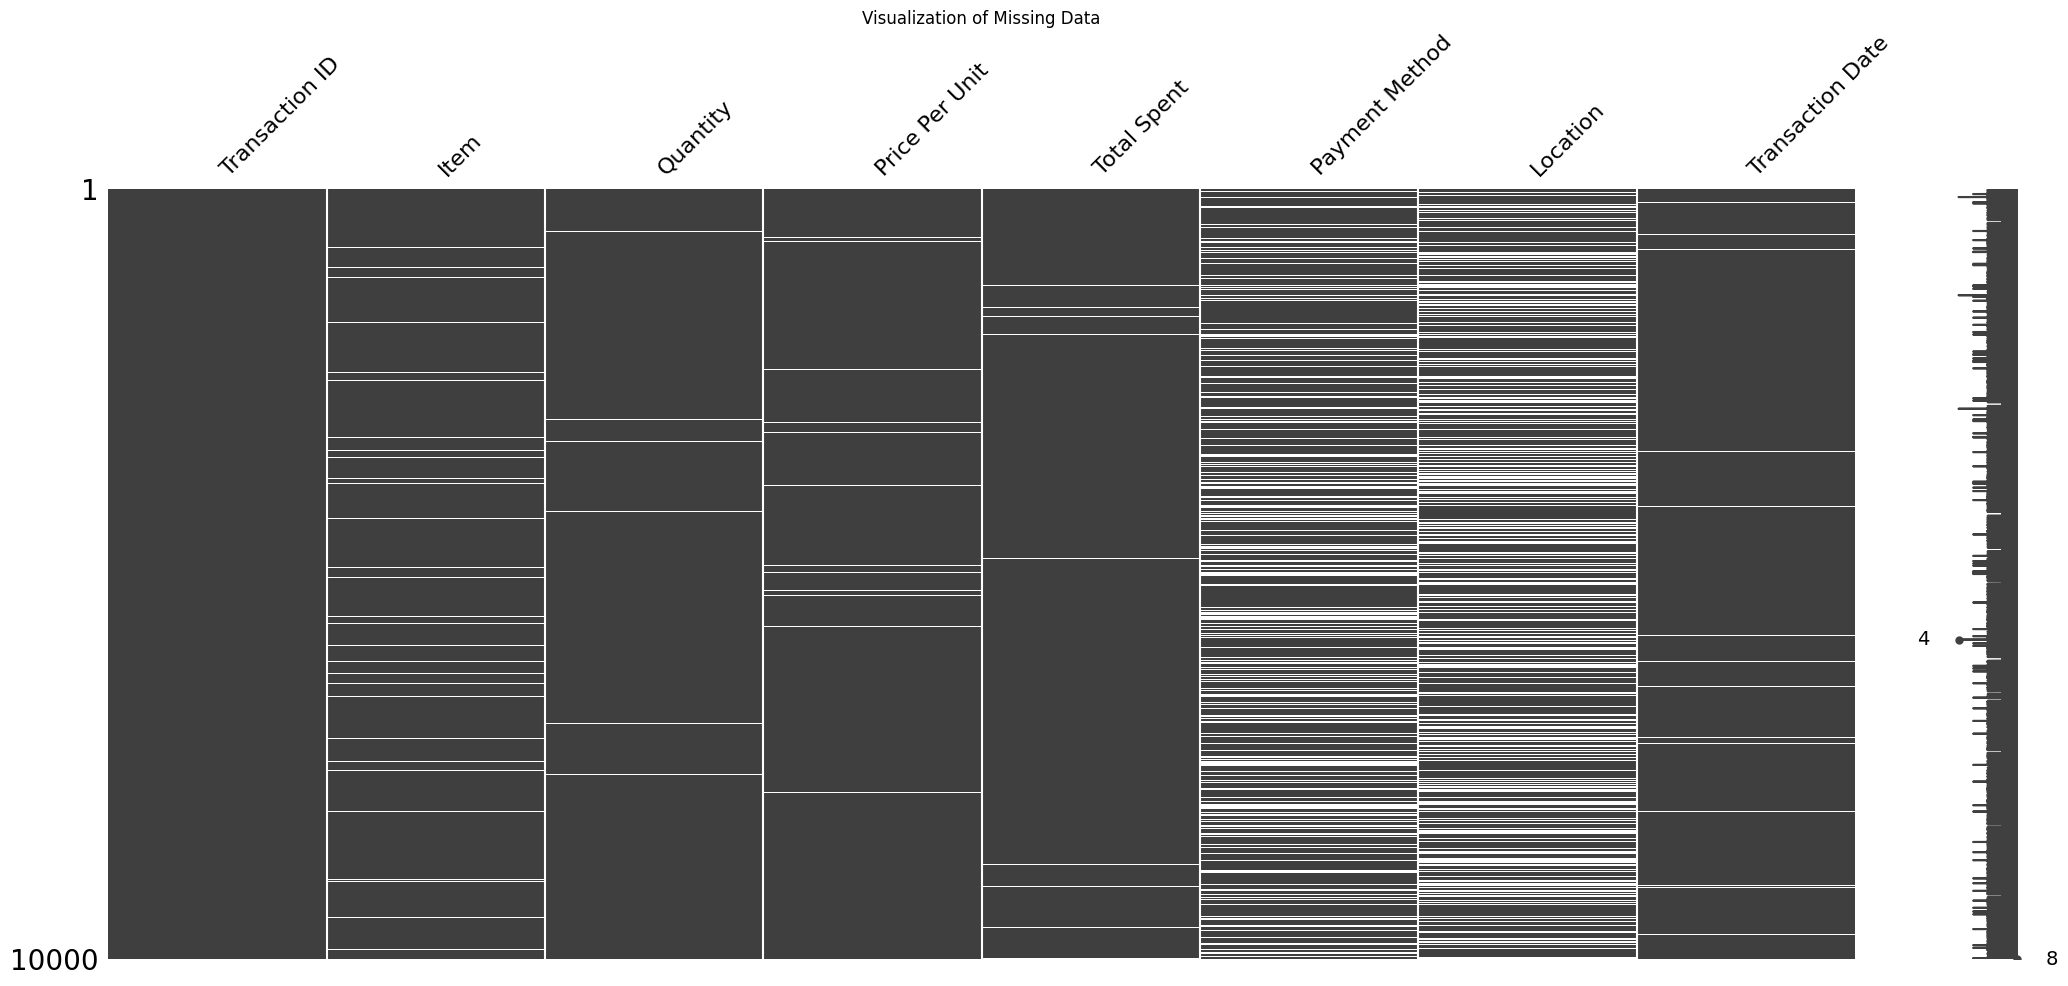

In [ ]:
plt.figure(figsize=(12, 8))
msno.matrix(df)
plt.title("Visualization of Missing Data")
plt.show();

In [ ]:
df['Item'].fillna(df['Item'].mode()[0], inplace=True)

df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Quantity'].fillna(df['Quantity'].median(), inplace=True)

df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')
df['Price Per Unit'] = df.groupby('Item')['Price Per Unit'].transform(
    lambda x: x.fillna(x.median())
)

df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')
df['Total Spent'].fillna(df['Quantity'] * df['Price Per Unit'], inplace=True)

df['Payment Method'].fillna(df['Payment Method'].mode()[0], inplace=True)

df['Location'].fillna(df['Location'].mode()[0], inplace=True)

df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')
df['Transaction Date'].fillna(method='ffill', inplace=True)

<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Item Distribution
</h3>

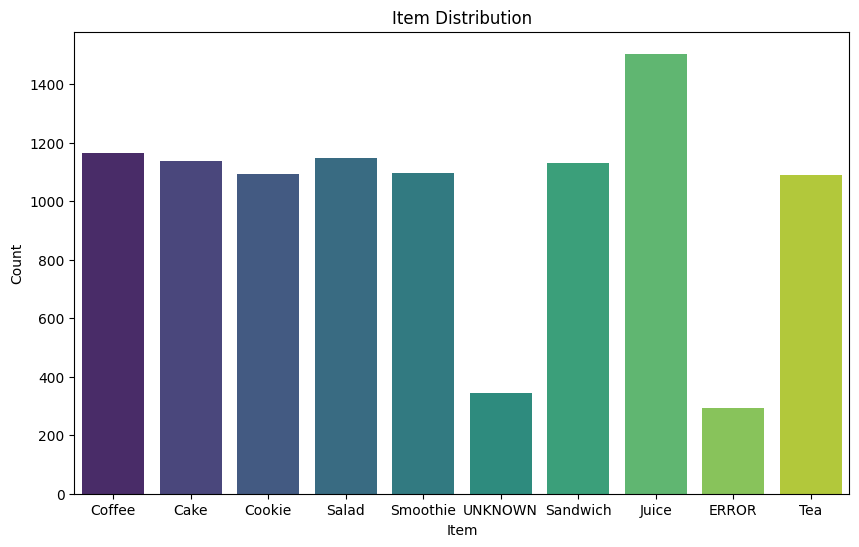

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Item', data=df, palette='viridis')
plt.title('Item Distribution')
plt.xlabel('Item')
plt.ylabel('Count')
plt.show()


<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Total Spent by Item
</h3>

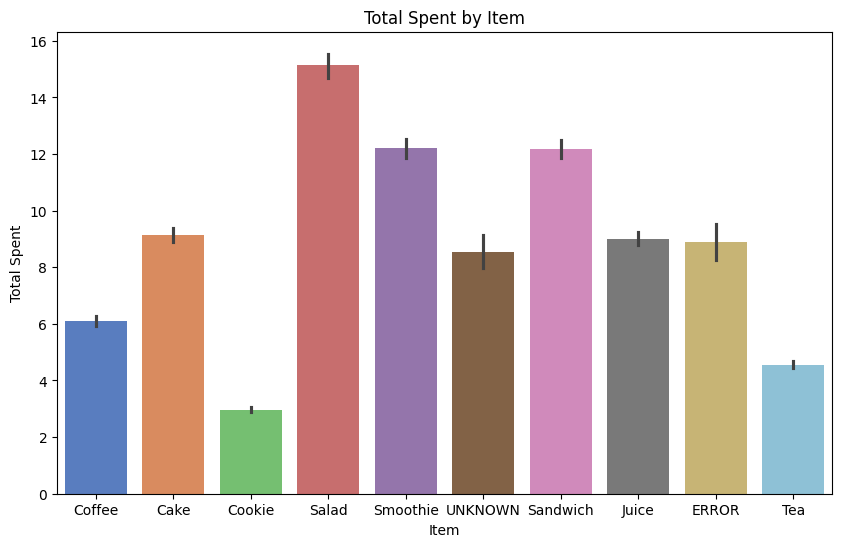

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Item', y='Total Spent', data=df, palette='muted')
plt.title('Total Spent by Item')
plt.xlabel('Item')
plt.ylabel('Total Spent')
plt.show()

<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Quantity vs. Price Per Unit
</h3>

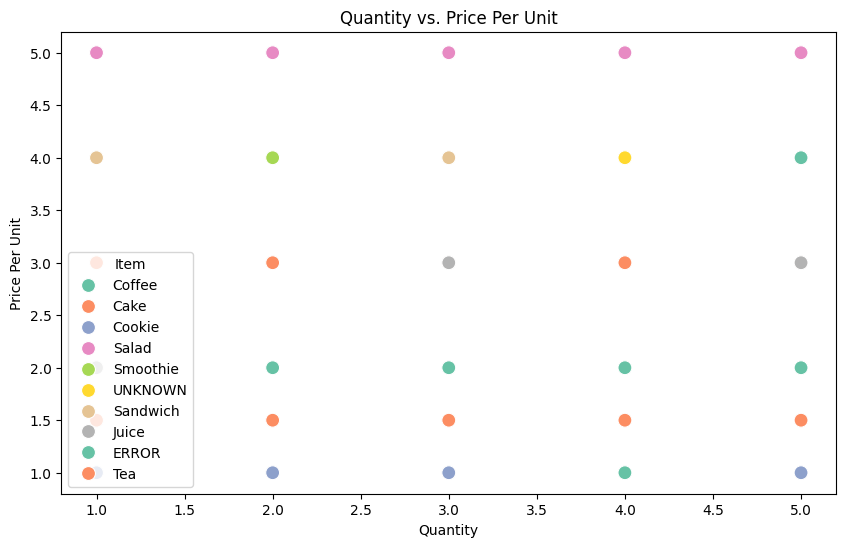

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='Price Per Unit', data=df, hue='Item', palette='Set2', s=100)
plt.title('Quantity vs. Price Per Unit')
plt.xlabel('Quantity')
plt.ylabel('Price Per Unit')
plt.show()

<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Spending Distribution by Payment Method
</h3>

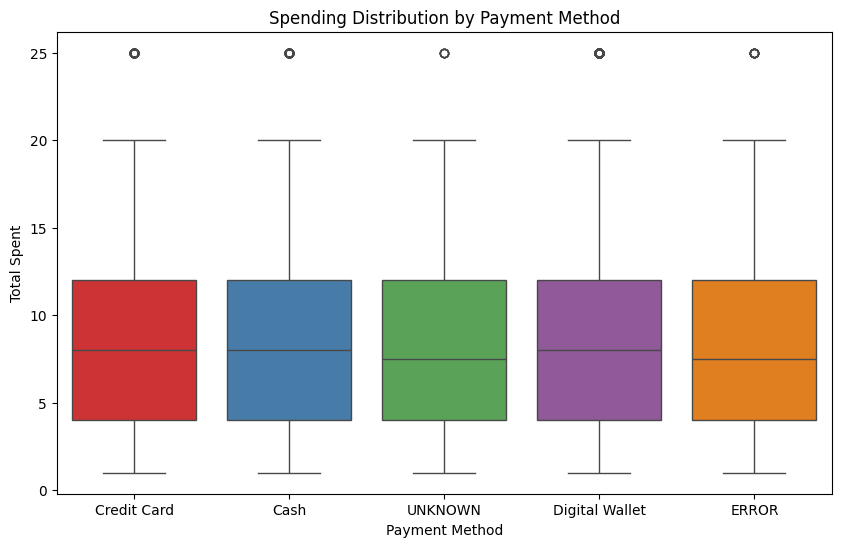

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Payment Method', y='Total Spent', data=df, palette='Set1')
plt.title('Spending Distribution by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Spent')
plt.show()

<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Total Spending by Location
</h3>

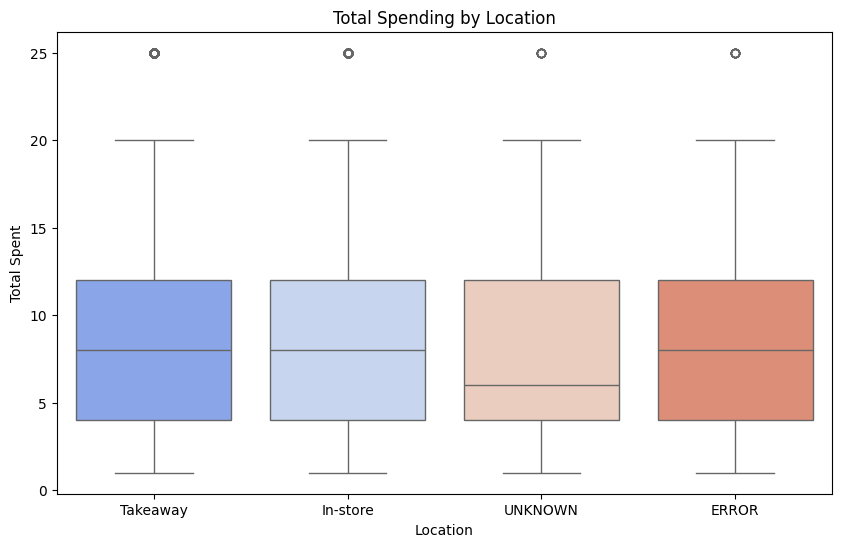

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Location', y='Total Spent', data=df, palette='coolwarm')
plt.title('Total Spending by Location')
plt.xlabel('Location')
plt.ylabel('Total Spent')
plt.show()


<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Total Spending Over Time
</h3>

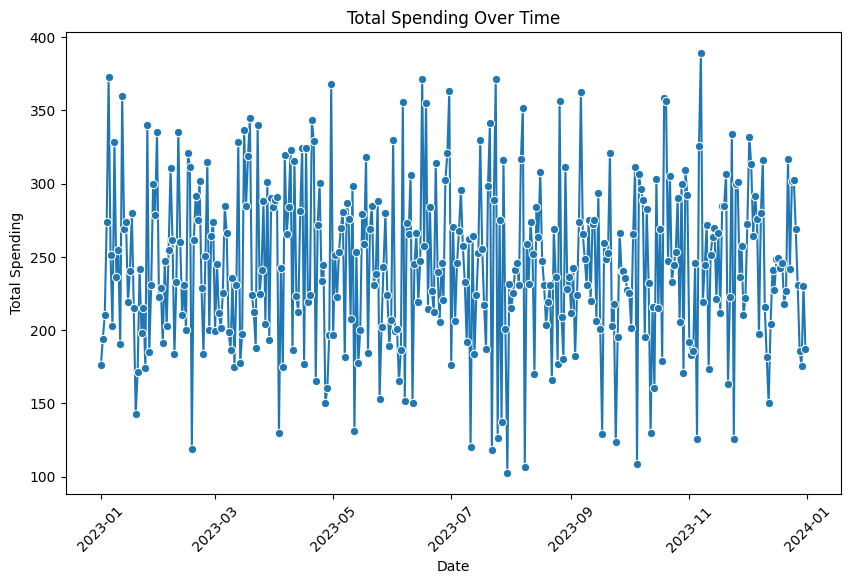

In [ ]:
plt.figure(figsize=(10, 6))
df_grouped_by_date = df.groupby('Transaction Date')['Total Spent'].sum().reset_index()
sns.lineplot(x='Transaction Date', y='Total Spent', data=df_grouped_by_date, marker='o')
plt.title('Total Spending Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spending')
plt.xticks(rotation=45)
plt.show()

<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Distribution of Price Per Unit
</h3>

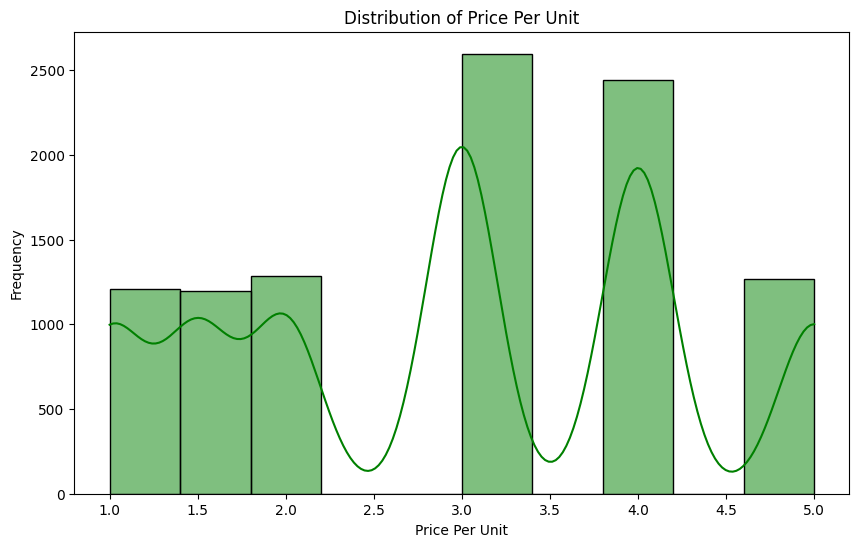

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price Per Unit'], bins=10, kde=True, color='green')
plt.title('Distribution of Price Per Unit')
plt.xlabel('Price Per Unit')
plt.ylabel('Frequency')
plt.show()

<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Distribution of Total Spending
</h3>

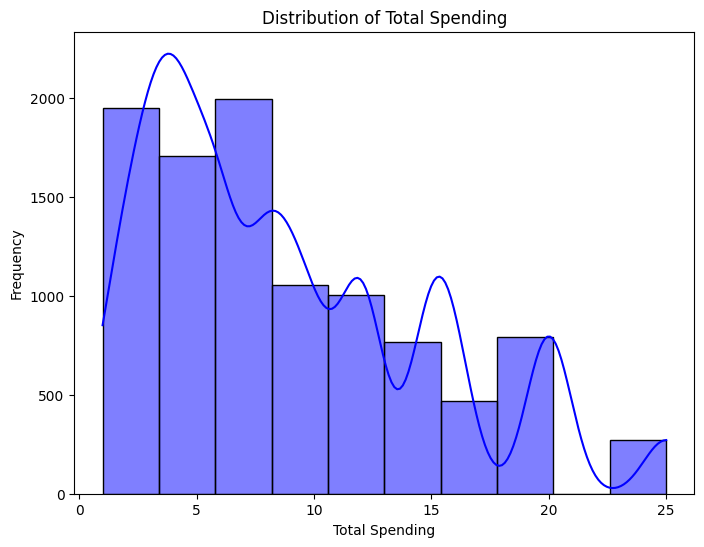

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Total Spent'], bins=10, kde=True, color='blue')
plt.title('Distribution of Total Spending')
plt.xlabel('Total Spending')
plt.ylabel('Frequency')
plt.show()

<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Removing variables that will not be used in model training
</h3>

In [ ]:
df = df.drop(columns=['Transaction ID','Transaction Date'])

<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Label Encoder
</h3>

In [ ]:
encoder = LabelEncoder()

label_mappings = {}

for col in df.select_dtypes('object'):
    df[col] = encoder.fit_transform(df[col])
    label_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

for col, mapping in label_mappings.items():
    print(f"Column: {col}")
    for label, code in mapping.items():
        print(f"{code} -> {label}")
    print()

Column: Item
0 -> Cake
1 -> Coffee
2 -> Cookie
3 -> ERROR
4 -> Juice
5 -> Salad
6 -> Sandwich
7 -> Smoothie
8 -> Tea
9 -> UNKNOWN

Column: Payment Method
0 -> Cash
1 -> Credit Card
2 -> Digital Wallet
3 -> ERROR
4 -> UNKNOWN

Column: Location
0 -> ERROR
1 -> In-store
2 -> Takeaway
3 -> UNKNOWN



<h1 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Machine Learning 🤖
</h1>

<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Train Test Split
</h3>

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Total Spent',axis = 1)
y = df['Total Spent']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)

(8000, 5) (2000, 5)


<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  KNN
</h3>

In [ ]:
knn = KNeighborsRegressor()
knn_model = knn.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [ ]:
knn_mse = mean_squared_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {knn_mse}")
print(f"R2 Score: {knn_r2}")

Mean Squared Error: 1.44437
R2 Score: 0.9598587958516966


<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Linear Regression
</h3>

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [ ]:
lr_mse = mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {lr_mse}")
print(f"R2 Score: {lr_r2}")

Mean Squared Error: 4.213540960017109
R2 Score: 0.8828993901401408


<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  XGBoost
</h3>

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train),
y_pred = xgb_model.predict(X_test)

In [ ]:
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {xgb_mse}")
print(f"R2 Score: {xgb_r2}")

Mean Squared Error: 1.1040796497343206
R2 Score: 0.969315974012218


<h3 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  All Results
</h3>

In [ ]:
models = ['KNN', 'XGBoost','Linear Regression']
mse_scores = [knn_mse, xgb_mse, lr_mse]
r2_scores = [knn_r2, xgb_r2, lr_r2]

mse_values = [f'{score:.4f}' for score in mse_scores]
r2_values = [f'{score:.4f}' for score in r2_scores]

results_df = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'R^2': r2_values
})
print(results_df)

               Model     MSE     R^2
0                KNN  1.4444  0.9599
1            XGBoost  1.1041  0.9693
2  Linear Regression  4.2135  0.8829


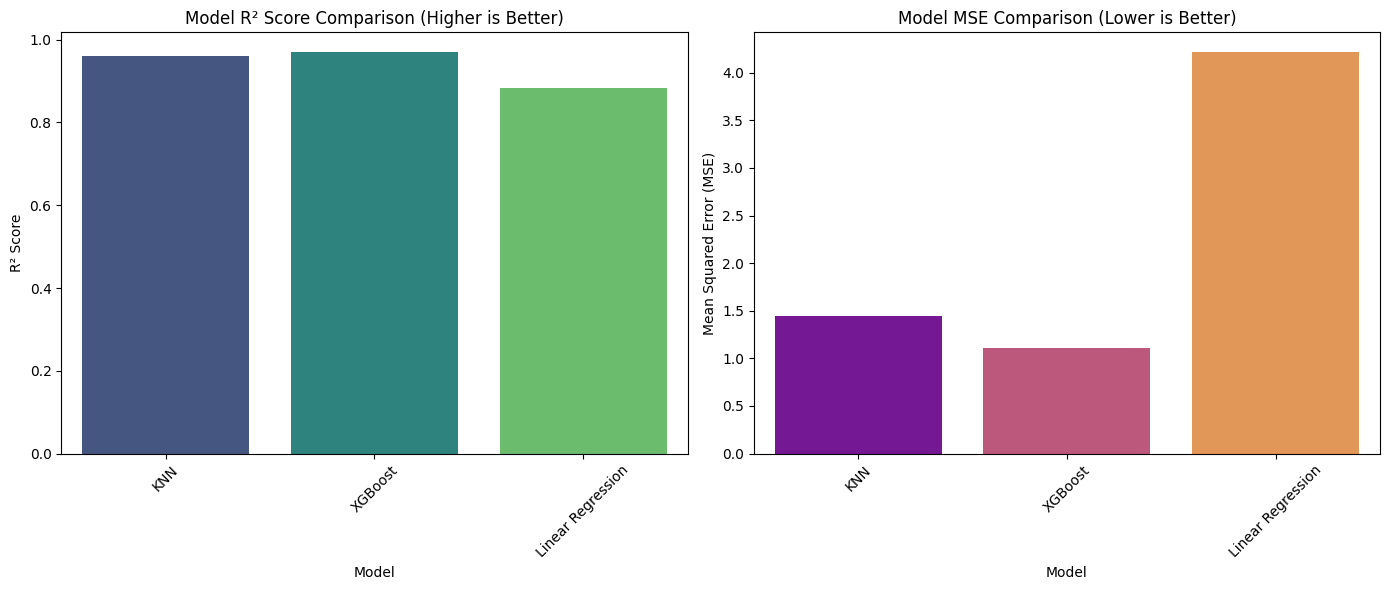

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# البيانات المستخلصة من قسم التقييم (Figure 17)
models = ['KNN', 'XGBoost', 'Linear Regression']

# MSE: القيم من جدول التقييم (MSE)
mse_scores = [1.4444, 1.1041, 4.2135]

# R2 Score: القيم من جدول التقييم (R^2)
r2_scores = [0.9599, 0.9693, 0.8829]

df_results = pd.DataFrame({
    'Model': models,
    'MSE': mse_scores,
    'R^2': r2_scores
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# الرسم البياني لـ R^2 Score
sns.barplot(x='Model', y='R^2', data=df_results, ax=axes[0], palette='viridis')
axes[0].set_title('Model R² Score Comparison (Higher is Better)')
axes[0].set_ylabel('R² Score')
axes[0].tick_params(axis='x', rotation=45)

# الرسم البياني لـ MSE
sns.barplot(x='Model', y='MSE', data=df_results, ax=axes[1], palette='plasma')
axes[1].set_title('Model MSE Comparison (Lower is Better)')
axes[1].set_ylabel('Mean Squared Error (MSE)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('model_comparison_mse_r2.png')
plt.show()

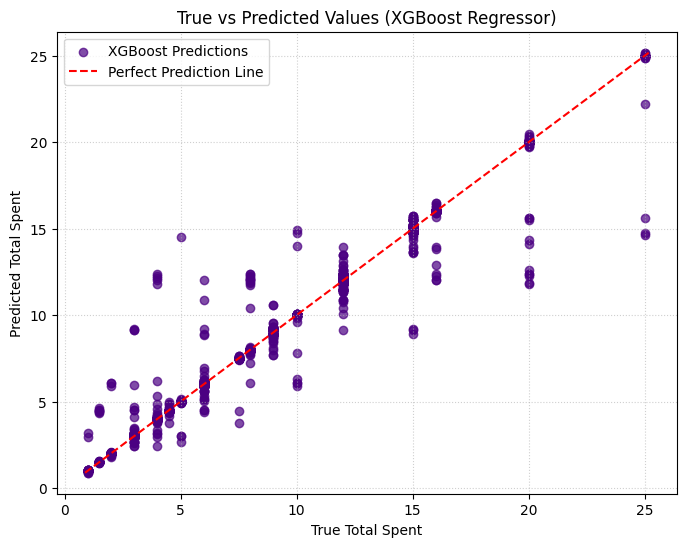

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# تأكد من أن y_pred_xgb و y_test معرفان لديك

# afTard ‘ank Qmt binshA’ y_pred_xgb mSbaqaً:
# y_pred_xgb = xgb_model.predict(X_test)

# rsm mqArnh bIn AlqIm AlhqYqyh wAlmtwqaA
plt.figure(figsize=(8, 6))

# mKHtat AlAntShAr llqIm AlfAlya wAlmtwqaA
plt.scatter(y_test, y_pred, alpha=0.7, color='indigo', label='XGBoost Predictions')

# rsm KHt mthAly bzAwyp 45 drjh (Hith y_pred = y_test)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction Line')

plt.title('True vs Predicted Values (XGBoost Regressor)')
plt.xlabel('True Total Spent')
plt.ylabel('Predicted Total Spent')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.savefig('xgb_true_vs_pred.png')
plt.show()

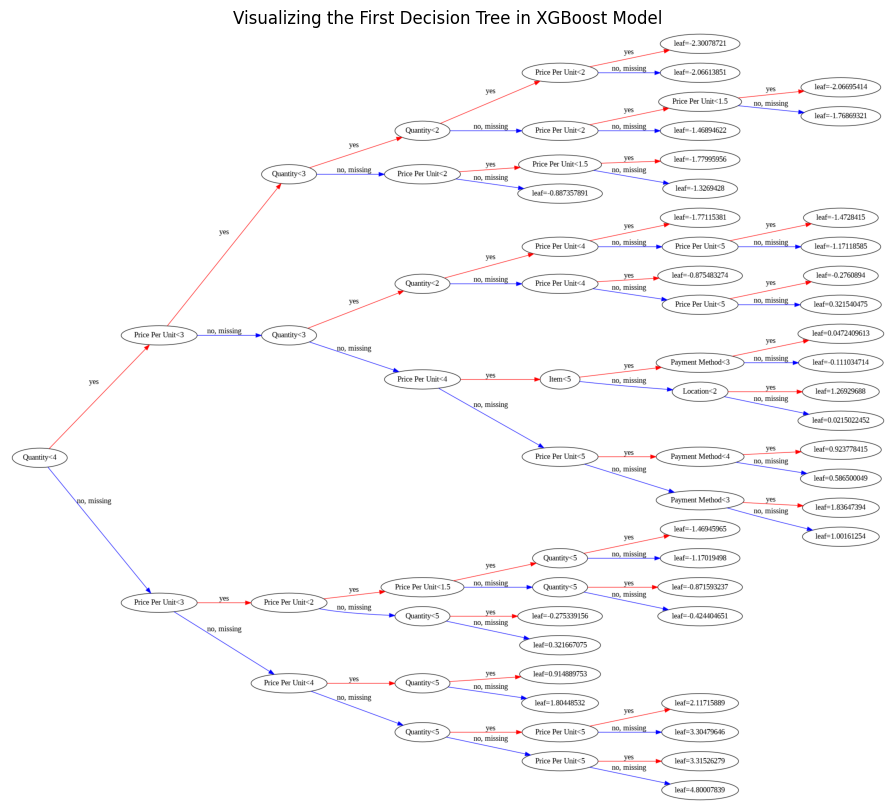

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
# تأكد من أن xgb_model مُدرب لديك

# رسم أول شجرة في النموذج (لأن XGBoost هو نموذج مجموعة)
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_tree(xgb_model, num_trees=0, ax=ax, rankdir='LR') # 'num_trees=0' لعرض أول شجرة فقط
plt.title("Visualizing the First Decision Tree in XGBoost Model")

# يمكنك استخدام plot_tree (rankdir='LR') لعرض أفقي أفضل
plt.savefig('xgb_tree_visualization.png')
plt.show()

# ملاحظة: إذا كان النموذج كبيراً جداً، فقد يكون رسم الشجرة معقداً ويستهلك موارد كثيرة.